Deep Learning Introduction

Resources used: https://course.fast.ai/

In [1]:
import fastai
import pandas as pd
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.collab import *
from time import sleep

#A function that takes a string and int and gives back a list of images equal to max using duckduckgo_search functions
#itemgot returns the url of the image and can be changed.
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Deep Learning is the idea of extracting and transforming data using layers of neural networks. Each layer takes as input the previous layer and refines the data more until all the layers have been processed. Deep Learning as a whole is just an area within Machine Learning.

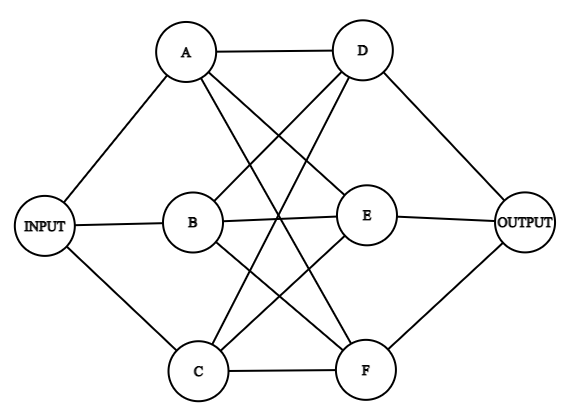


Between the input and output are hidden layers which transform the input and lead to a output. Hidden layers are used to break down parts of the input that can be used to lead up to an input. An example can be one hidden layer is used to recognize wheels while another hidden layer is used to find windows. Both in tangent can be used along with as many others to detect whether the input is a car or not.


Applications of Deep Learning:

Image recognition and art generation, Video game AI, Recommendation Systems, Medicine and Biology, Robotics

In [3]:
#Create a list of urls that holds images equal to max images
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

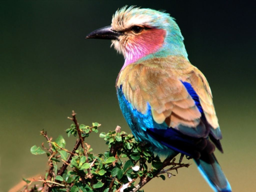

In [4]:
#Assign the image to dest and download it before opening the image. Resize the image to 256 x 256
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'car photos'


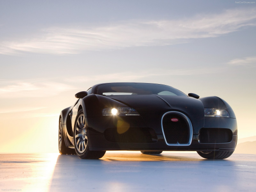

In [5]:
#Shorter code to repeat the two cells above
download_url(search_images('car photos', max_images=1)[0], 'car.jpg', show_progress=True)
Image.open('car.jpg').to_thumb(256,256)

In [6]:
searches = 'car','bird','desert','dog'
path = Path('dataset')

#Grabs 30 images of each since our default for search_images is 30.
#Creates a new directory called dataset and then puts all the images into the directory after resizing the image to 400
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'car photo'
Searching for 'bird photo'
Searching for 'desert photo'
Searching for 'dog photo'


In [7]:
#Checks to see if all the images have loaded correctly. Removes images that don't load correctly
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

In [8]:
#Definitions
#blocks(Number of images, what the model should output)
#A function that returns a list of all the image files from the path
#Splitter: Separate a portion of data that is used to evaluate the data (Evaluation Set)
#A function that tells the model what the actual answer is by returning parent folder of a path
#Resizes all the images to 256 x 256 that can either be cropped or squished
#The dataloader is what feeds the images to the model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

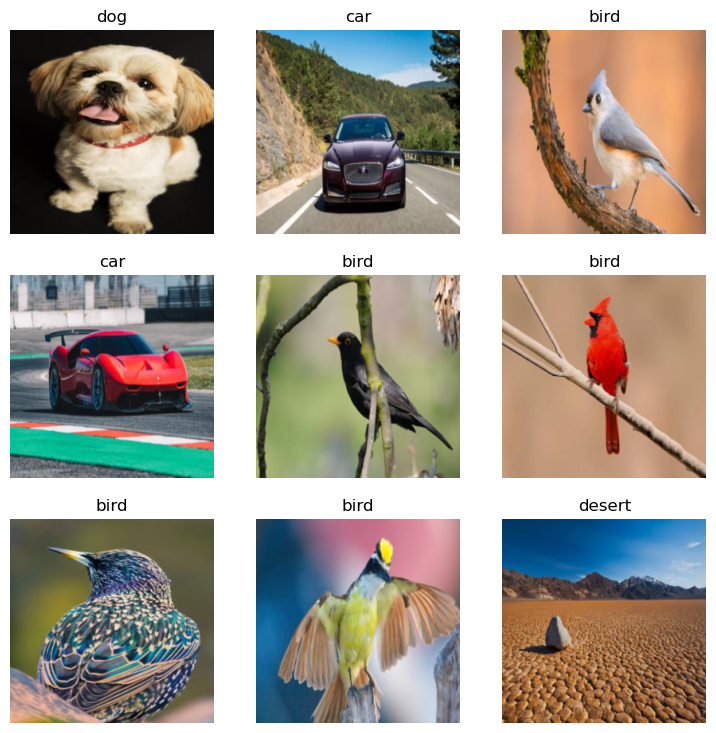

In [9]:
#Show a example of data that is going to be entered inside the model
dls.show_batch(max_n=9)

In [10]:
#Downloads a pretrained model and trains through the data we gave it. By using a pretrained model, it means
#someone else trained the model on another dataset and we're just adjusting the weights to fit ours.
#train_loss and valid_loss represents how off we are compared to the learner and the actual datset
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

E:\Conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.195414,0.004881,0.000000,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.016229,0.000387,0.000000,00:31
1,0.009861,0.000107,0.000000,00:32
2,0.006543,0.000065,0.000000,00:32


In [11]:
#Tests the learner against a bird. The first line of code holds values from the learner
#(string of whether bird or not, int of whether bird or not, probability of bird)
a,a1,prob1 = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {a}.")
print(f"Is bird: {a1}.")
print(f"Probability it's a bird: {prob1[0]:.4f}")

This is a: bird.
Is bird: 0.
Probability it's a bird: 1.0000


In [12]:
#Uses a car jpg and see if what the learner thinks
b,b2,prob2 = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {b}.")
print(f"Is bird: {b2}.")
print(f"Probability it's a bird: {prob2[0]:.4f}")

This is a: car.
Is bird: 1.
Probability it's a bird: 0.0000


In normal programming, we just figure out the exact steps required to do a certain task and translate that into code. That doesn't work however when the question is asking to diffrentiate between a picture of a bird and car. Instead of writing down steps, we give the program examples and tell it to figure it out from there. This type of program is referred to as model.

In a model, there are variables called weights (model parameters). These are similar as input and serve to dictate the model how much a certain thing impacts it's decision. When the model outputs a result, we compare the result to the answers and then adjust the weights accordingly. Think of it as a loop.

Inputs and Weights -> Model -> Result -> Compare -> New Inputs and Weights


If the program can automatically adjust its weights and inputs to match the problem, doesn't that mean we can use this model for various things than just birds and cars? It does which is why neural networks are very powerful. Neural networks are special because they are flexible and can solve problems by simply adjusting the weights.

In [34]:
#Collaborative Filtering: Recommendation System. 
#Search a group of people, find a smaller group within that all have similar opinions of a certain user
#If two users have similar likes or use of a product, recommendations can be products on what each user hasn't used yet.
#Source of dataset: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
df = pd.read_csv('food.csv')
df = df.dropna()
dls3 = CollabDataLoaders.from_df(df, item_name = 'ProductId',
rating_name = 'Score')
dls3.show_batch()

,UserId,ProductId,Score
0,AB9PLGWI1YLH2,B005BRHVD6,4
1,AQ1SOXTOY0WH2,B0027049E4,5
2,A35LT14WG5BX0T,B0029JB0CW,5
3,A1SGBCM7XUC5HF,B001FA1KXU,5
4,A22RXNCWIC1OCD,B004DNESJO,5
5,ACAINJEMTPISY,B0032GREWQ,1
6,ADLVFFE4VBT8,B000CQC08C,5
7,ACNM1HQ5HS2T5,B001AT1HH0,5
8,AWHBNT6Z8VO72,B0007GFDP4,5
9,A1OP7O7OLH0AKM,B001CHFSR0,5


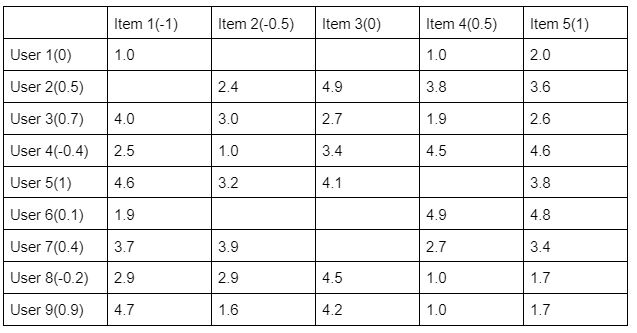

The above table gives us a representation on what collaborative filtering is supposed to do. Here, we are given a list of users and which products they rated. The blanks represent that the user has not used that item. We can predict what these values are by finding similar users that have used said item and matching. The items that we predict that gives us a high score are ones we recommend to the user.

Obviously we need to find a way to identify what qualifies as a similar user or similar item for collaborative filtering to work. That is why we use a scalar that describes the category the item or user fits in.

Using movie ratings as an example, -1 can represent leaning toward movies tailored toward younger audiences while 1 is for adult audiences. With that value integrated into our table, we can see now what movies and users are similar. It's possible to add more scalars if needed to be more specific on what our user's preferences are.

In [38]:
#Downloads a pretrained model and trains through the data we gave it. y_range: range of output lr: learning rate
learn3 = collab_learner(dls3, y_range=(0.0,5.0), lr=0.1)
learn3.fine_tune(1)

epoch,train_loss,valid_loss,time
0,3.004750,3.049990,28:04


epoch,train_loss,valid_loss,time
0,2.508944,2.689106,31:38


In [39]:
learn3.show_results()

,UserId,ProductId,Score,Score_pred
0,246908,18017,5,3.733614
1,166830,33593,5,4.912965
2,62351,24033,5,4.558016
3,230123,8649,5,2.889706
4,153884,41756,1,2.527328
5,254886,20299,5,2.610744
6,149945,46530,5,4.743962
7,180174,9055,5,2.885010
8,157939,62451,2,2.598153


In [16]:
#Another example using a movie example dataset given by fastai
path = untar_data(URLs.ML_SAMPLE)
dls4 = CollabDataLoaders.from_csv(path/'ratings.csv')
dls4.show_batch()

,userId,movieId,rating
0,475,4993,5.0
1,537,1617,3.0
2,480,367,3.5
3,380,47,5.0
4,268,1097,3.5
5,128,380,4.0
6,56,58559,5.0
7,431,1097,5.0
8,346,4993,4.0
9,430,2918,5.0


In [17]:
learn4 = collab_learner(dls4, y_range=(0.5,5.5))
learn4.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.523833,1.390003,00:00


epoch,train_loss,valid_loss,time
0,1.360321,1.328647,00:00
1,1.255762,1.144695,00:00
2,1.010920,0.857939,00:00
3,0.792921,0.732389,00:00
4,0.694830,0.702349,00:00
5,0.645665,0.693269,00:00
6,0.623263,0.689539,00:00
7,0.606408,0.688035,00:00
8,0.605113,0.687110,00:00
9,0.603876,0.687050,00:00


In [18]:
learn4.show_results()

,userId,movieId,rating,rating_pred
0,90.0,52.0,4.0,4.219285
1,58.0,99.0,3.5,4.020137
2,95.0,26.0,4.0,3.953664
3,14.0,61.0,4.5,3.890131
4,62.0,58.0,3.5,3.862350
5,16.0,31.0,4.0,4.232532
6,49.0,19.0,4.0,2.662464
7,16.0,72.0,3.0,3.279310
8,34.0,42.0,5.0,3.673727


Limitations of Deep Learning

Deep Learning doesn't require a lot of data, but there needs to be something for the model to work with.
The model is only as effective as the data we give it. New data that doesn't match at all with the model will be far off.
There needs to be a way to check answers. The image learner had tags for each image and the collab learner had a number.
Deep Learning only gives predictions, not solutions.

In [19]:
#Deep Learning for tabular data
df = pd.read_csv("aita.csv")

In [20]:
#Removing all columns that don't have any value for the learner
df = df.drop(['id', 'timestamp', 'body', 'title'], axis=1)

In [21]:
#The value we are trying to predict is is_asshole. Cat_names are columns with set value such as booleans whole cont_names
#are categories such as all real numbers. The procs are functions to optimize our data.
dls = TabularDataLoaders.from_df(df, path=path, y_names="is_asshole",
    cat_names = ['edited'],
    cont_names = ['score', 'num_comments'],
    procs = [Categorify, FillMissing, Normalize])

In [22]:
dls.show_batch()

,edited,score,num_comments,is_asshole
0,False,4.000008,7.999996,True
1,False,3.000003,26.000000,False
2,False,103.999994,95.000000,False
3,True,543.000006,161.999998,False
4,True,21.000004,75.000000,False
5,True,62.999989,88.000000,True
6,True,71.000009,18.999998,False
7,True,4.999989,16.999998,False
8,False,4.000008,4.999998,True
9,False,4.000008,10.000000,False


In [23]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.738026,0.704486,0.260000,00:00
1,0.699943,0.713700,0.275000,00:00
2,0.685188,0.646301,0.730000,00:00
3,0.664840,0.631029,0.735000,00:00
4,0.648846,0.621092,0.740000,00:00


In [24]:
learn.show_results()

,edited,score,num_comments,is_asshole,is_asshole_pred
0,1.0,-0.177780,-0.284485,0.0,0.0
1,2.0,-0.155118,0.089790,0.0,1.0
2,1.0,-0.176037,-0.216759,1.0,0.0
3,1.0,-0.177780,0.071968,1.0,1.0
4,2.0,-0.159766,-0.238146,0.0,0.0
5,1.0,-0.178361,-0.255969,0.0,0.0
6,1.0,-0.174875,-0.241711,0.0,0.0
7,1.0,-0.175456,-0.206065,0.0,0.0
8,1.0,-0.171969,-0.252404,0.0,0.0


In [25]:
#Unsurprisingly, if we feed the learner the verdict column, the accuracy is pretty much dead on.
dls = TabularDataLoaders.from_df(df, path=path, y_names="is_asshole",
    cat_names = ['verdict', 'edited'],
    cont_names = ['score', 'num_comments'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(5)
learn.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.679896,0.746446,0.265000,00:00
1,0.557238,0.685756,0.290000,00:00
2,0.427301,0.564828,0.900000,00:00
3,0.332397,0.434695,0.920000,00:00
4,0.269858,0.329375,0.925000,00:00


,verdict,edited,score,num_comments,is_asshole,is_asshole_pred
0,4.0,1.0,-0.185701,-0.205235,0.0,0.0
1,4.0,1.0,-0.184458,-0.243684,0.0,0.0
2,4.0,1.0,-0.181972,-0.262909,0.0,0.0
3,4.0,1.0,-0.185079,-0.324427,0.0,0.0
4,3.0,2.0,-0.179485,-0.162942,0.0,0.0
5,2.0,1.0,1.746121,4.220230,1.0,0.0
6,1.0,2.0,-0.170783,-0.162942,1.0,1.0
7,4.0,1.0,-0.182593,-0.305202,0.0,0.0
8,4.0,1.0,-0.185079,-0.247529,0.0,0.0
